<a href="https://colab.research.google.com/github/gauraviiitv/notebooks/blob/main/Vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rarfile

In [ ]:
import requests
import rarfile
import io

# URL of the RAR file
url = "https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/1ae209c4-dfaf-4702-b00c-683448279b59"

# Send an HTTP GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Open the RAR file
    with rarfile.RarFile(io.BytesIO(response.content)) as rar_ref:
        # Extract all the contents to a directory
        rar_ref.extractall("")
    print("Extraction successful.")
else:
    print("Failed to download the RAR file.")


Extraction successful.


In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torchvision import datasets, models
from sklearn.metrics import confusion_matrix

In [ ]:
# Define paths to your datasets
train_dir = "Smoker Detection/Training"
val_dir = "Smoker Detection/Validation"
test_dir = "Smoker Detection/Testing"

# Define transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Define function to extract label from file name
def extract_label(filename):
    if "nonsmoker" in filename:
        return 0
    else:
        return 1

# Define custom dataset class to extract labels from file names
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.file_names = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_names[idx])
        image = datasets.folder.default_loader(img_name)  # Load image using torchvision
        label = extract_label(self.file_names[idx])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Create custom datasets
train_dataset = CustomDataset(train_dir, transform=transform, target_transform=torch.tensor)
val_dataset = CustomDataset(val_dir, transform=transform, target_transform=torch.tensor)
test_dataset = CustomDataset(test_dir, transform=transform, target_transform=torch.tensor)

# Define data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define Vision Transformer model
class VisionTransformer(nn.Module):
    def __init__(self, image_size=224, patch_size=16, num_classes=2, dim=768, depth=12, heads=12, mlp_dim=3072, dropout=0.1):
        super(VisionTransformer, self).__init__()
        num_patches = (image_size // patch_size) ** 2
        self.patch_size = patch_size
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.patch_embedding = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim, nhead=heads), num_layers=depth)
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == W == 224, 'Image size must be 224x224'
        x = self.patch_embedding(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.positional_embedding[:, :(x.shape[1])]
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x



# Initialize the model
model = VisionTransformer(image_size=224, patch_size=16, num_classes=2, dim=768, depth=12, heads=12, mlp_dim=3072, dropout=0.1)

# Print the model architecture
print(model)


VisionTransformer(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=768, out_features=2, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Step 3: Train the model

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return model, train_losses, val_losses

def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    val_loss /= len(dataloader.dataset)
    val_accuracy = accuracy_score(all_labels, all_predictions)

    return val_loss, val_accuracy

# Step 4: Evaluate the model on the test set

def test_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Calculate additional metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)

    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(cm)

# Step 5: Print and plot metrics

def plot_metrics(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Define hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Train the model
trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)


Epoch 1/5, Train Loss: 0.0567, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 2/5, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 3/5, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 4/5, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 5/5, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 1.0000


Test Loss: 0.0000, Test Accuracy: 1.0000
Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Confusion Matrix:
[[224]]


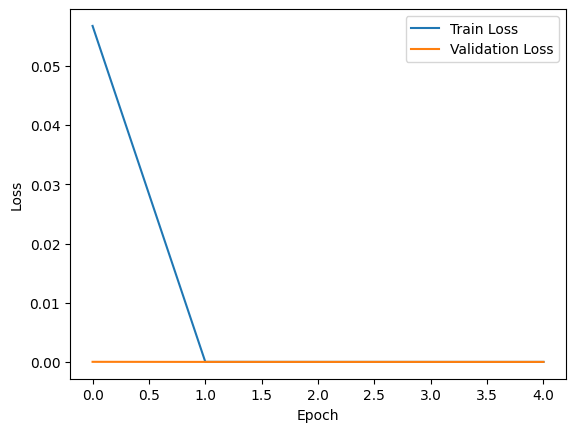

In [ ]:
# Evaluate on test set
test_model(trained_model, test_loader)

# Plot training and validation loss
plot_metrics(train_losses, val_losses)

In [ ]:
print("Size of train dataset:", len(train_dataset))
print("Size of validation dataset:", len(val_dataset))
print("Size of test dataset:", len(test_dataset))


Size of train dataset: 716
Size of validation dataset: 180
Size of test dataset: 224
